In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [2]:

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target


In [3]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


In [5]:

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [6]:

best_tree = grid_search.best_estimator_
best_params = grid_search.best_params_


In [7]:

untuned_tree = DecisionTreeClassifier(random_state=42, max_depth=1)
untuned_tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=1, random_state=42)

In [8]:

y_pred_tuned = best_tree.predict(X_test)
y_pred_untuned = untuned_tree.predict(X_test)


In [9]:

metrics = pd.DataFrame({
    'Model': ['Untuned (Stump)', 'Tuned'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_untuned),
        accuracy_score(y_test, y_pred_tuned)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, untuned_tree.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, best_tree.predict_proba(X_test)[:,1])
    ],
    'Params': [
        'max_depth=1',
        str(best_params)
    ]
})


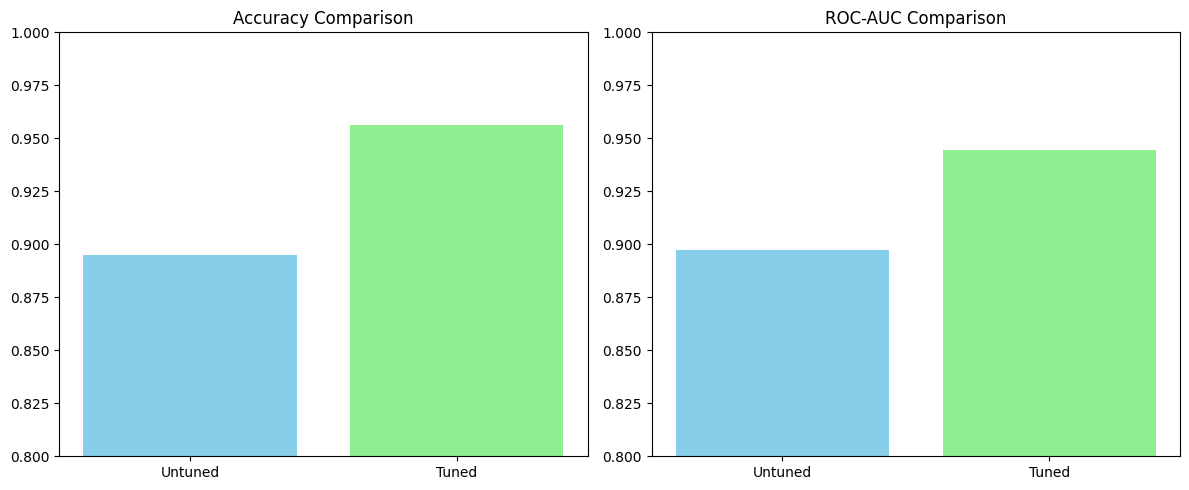

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Performance Comparison:
          Model  Accuracy  ROC-AUC                                                                                   Params
Untuned (Stump)  0.894737 0.897150                                                                              max_depth=1
          Tuned  0.956140 0.944317 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [10]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(['Untuned', 'Tuned'], metrics['Accuracy'], color=['skyblue', 'lightgreen'])
plt.title('Accuracy Comparison')
plt.ylim(0.8, 1.0)

plt.subplot(1, 2, 2)
plt.bar(['Untuned', 'Tuned'], metrics['ROC-AUC'], color=['skyblue', 'lightgreen'])
plt.title('ROC-AUC Comparison')
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

print("Optimal Parameters:", best_params)
print("\nPerformance Comparison:")
print(metrics.to_string(index=False))


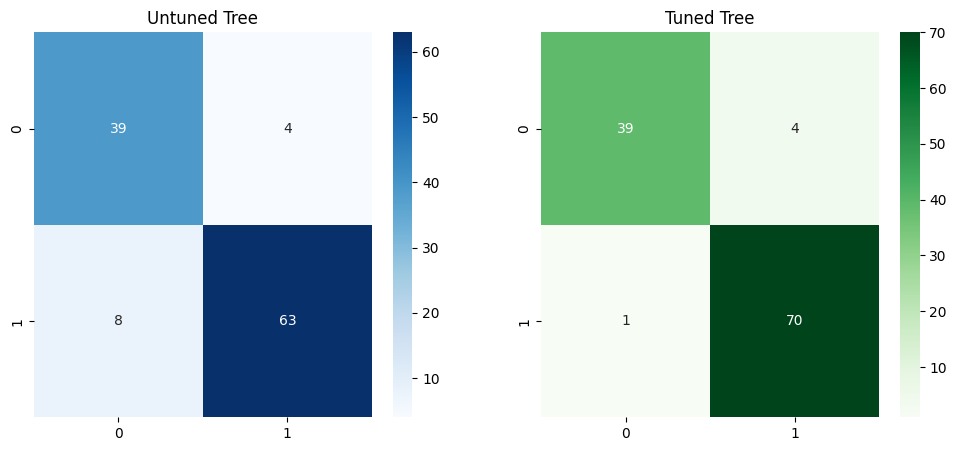

In [13]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_untuned), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Untuned Tree')
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Greens', ax=ax2)
ax2.set_title('Tuned Tree')
plt.show()


In [14]:

print("\nKey Observations:")
print("1. Tuning improved accuracy from {:.1%} to {:.1%}".format(
    metrics['Accuracy'][0], metrics['Accuracy'][1]))
print("2. The tuned tree uses {} with max_depth={}".format(
    best_params['criterion'], best_params['max_depth']))
print("3. The optimal min_samples_split={} prevents overfitting".format(
    best_params['min_samples_split']))
print("4. ROC-AUC improved from {:.3f} to {:.3f}".format(
    metrics['ROC-AUC'][0], metrics['ROC-AUC'][1]))


Key Observations:
1. Tuning improved accuracy from 89.5% to 95.6%
2. The tuned tree uses entropy with max_depth=5
3. The optimal min_samples_split=10 prevents overfitting
4. ROC-AUC improved from 0.897 to 0.944
